# Using scvi_de

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np

import scanpy as sc
import muon as mu

2024-04-16 12:09:06.758917: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 12:09:06.803300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 12:09:07.555304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




if scvi_de hasn't been installed, uncomment and run the following cell

In [ ]:
# %pip install -qq git+https://github.com/milescsmith/scvi_de@0.4.1

In [178]:
from scvi_de import scvi_de

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore')

In [7]:
project_folder = Path.home().joinpath(
    "workspace", "analysis", "ana_multiome"
)
notebook_folder = project_folder.joinpath("analysis", "notebooks")
data_folder = project_folder / "data"

Previously extracted the t-cell data from the full mudata object

In [8]:
raw_tcells = sc.read_h5ad("20240402_raw_tcells.h5ad")

scVI needs the raw integer counts to run - it WILL NOT work on normalized data.

scvi_de should check if the data looks correct before doing much of anything. It should look like the below:

In [181]:
raw_tcells.X.todense()[:5,:5]

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float32)

No need to run this cell if the data in X or the layer name you pass below contains integer counts.

In [ ]:
raw_tcells.raw = raw_tcells

raw_tcells.layers["counts"] = raw_tcells.X.copy()

Subsampling here just to speed things up.  Don't actually do this unless you need to.

In [12]:
sub_raw_t = sc.pp.subsample(raw_tcells, fraction=0.05, copy=True)

In [182]:
help(scvi_de)

Help on function scvi_de in module scvi_de:

scvi_de(adata: anndata._core.anndata.AnnData | None = None, model: scvi.model._scvi.SCVI | scvi.model._totalvi.TOTALVI | None = None, groupby: str = 'leiden', layer: str | None = None, modality: Literal['rna', 'prot'] = 'rna', compare_group: str | None = None, reference_group: str = 'rest', batch_correct: bool = False, batch_key: str | None = None, dispersion: Optional[Literal['gene', 'gene-batch', 'gene-label', 'gene-cell']] = None, gene_likelihood: Literal['nb', 'zinb', 'poisson'] = 'nb', remove_outliers: bool = False, inplace: bool = False, return_df: bool = False, return_model: bool = False, lfc_use: Literal['lfc_mean', 'lfc_median', 'lfc_max', 'lfc_min'] = 'lfc_mean', **kwargs) -> dict[str, pandas.core.frame.DataFrame | anndata._core.anndata.AnnData | scvi.model._scvi.SCVI | scvi.model._totalvi.TOTALVI] | None
    Perform differential expression analysis using the scVI suite of tools
    
    Parameters
    -------
    adata : anndata.A

In [185]:
degs = scvi_de(
    adata=sub_raw_t,
    groupby="leiden_wnn_0.9",
    modality="rna",
    return_df=True,
    return_model=True,
    dispersion="gene-batch",
    gene_likelihood="zinb",
)

Sampling from binomial...: 100%|██████████| 10000/10000 [00:19<00:00, 521.72it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 220/400:  55%|█████▌    | 220/400 [07:54<06:27,  2.16s/it, v_num=1, train_loss_step=2.35e+3, train_loss_epoch=2.3e+3] 
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 2333.146. Signaling Trainer to stop.
DE...: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


By default, the function should return:
* an adata object
* a dictionary of dataframes, with one dataframe for each comparison
* the model that was generated (or used). this can be used in further runs of `scvi_de`

In [186]:
degs.keys()

dict_keys(['adata', 'deg_df', 'model'])

For example, in this instance I did a each cluster versus the rest comparison so I get a dictionary with a dataframe for each cluster:

In [187]:
degs['deg_df'].keys()

dict_keys(['9', '3', '1', '0', '4', '2', '11', '5', '8', '12', '7', '6', '10', '14', '13', '15', '18', '16', '17'])

In [189]:
df = degs['deg_df']['1']

In [200]:
df.head()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
PASK,0.9714,0.0286,3.525331,0.000020,0.000156,0.0,0.25,-2.795641,-3.112103,2.620477,-10.014138,6.946982,0.024429,0.169130,0.022305,0.119732,0.165551,1.227632,True
AQP3,0.9704,0.0296,3.489934,0.000036,0.000303,0.0,0.25,-2.967551,-3.187868,2.125046,-9.186669,6.896668,0.022305,0.398442,0.021243,0.251156,0.163711,2.854752,True
PRSS23,0.9696,0.0304,3.462441,0.000215,0.000052,0.0,0.25,5.040472,5.561466,3.781550,-8.837938,15.489596,0.309081,0.060545,0.231014,0.046950,2.213014,0.480922,True
CCR7,0.9666,0.0334,3.365229,0.000046,0.000388,0.0,0.25,-3.046691,-3.309097,2.612986,-9.117955,7.211918,0.012746,0.484909,0.010621,0.259947,0.096357,3.553638,True
FGFBP2,0.9664,0.0336,3.359051,0.001450,0.000410,0.0,0.25,3.991240,4.324495,3.047870,-5.922016,12.854061,1.719606,0.405058,0.592140,0.143660,12.805597,3.320689,True


The important columns are:
* `proba_de` - probability that the feature *is* differentially expressed
* `proba_not_de` - probability that the feature *is* **NOT** differentially expressed. This is essentially the adjusted p-value.
* `lfc_mean` - Mean log-fold change for the group.
* `non_zeros_proportion1` - proportion of zero values for cells *in* the group of interest
* `non_zeros_proportion2` - proportion of zero values for cells *outside* the group of interest
* `is_de_fdr_0.05` - is the feature significantly differently expressed?

So, we can look at the top 5 significant DEGs expressed in over 50% of the cells in cluster 1, sorted by log-fold change:

In [207]:
df[(df["proba_de"] > 0.95) & (df["non_zeros_proportion1"] > 0.5)].sort_values(by="lfc_mean", ascending=False).head()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
GZMH,0.9562,0.0438,3.083333,0.003043,0.000735,0.0,0.25,4.363708,4.739703,3.026137,-4.632605,13.204952,4.048316,0.767610,0.859267,0.198677,29.876085,6.347984,True
CCL4,0.9558,0.0442,3.073824,0.001034,0.000309,0.0,0.25,4.289329,4.465241,3.459160,-4.822578,15.601782,1.258106,0.305540,0.509825,0.121998,9.876792,2.731168,True
GZMB,0.9652,0.0348,3.322718,0.001501,0.000384,0.0,0.25,4.179798,4.621313,2.995448,-5.492234,12.466099,1.853437,0.360193,0.619225,0.128342,13.428296,2.975245,True
FGFBP2,0.9664,0.0336,3.359051,0.001450,0.000410,0.0,0.25,3.991240,4.324495,3.047870,-5.922016,12.854061,1.719606,0.405058,0.592140,0.143660,12.805597,3.320689,True
PRF1,0.9576,0.0424,3.117282,0.001072,0.000346,0.0,0.25,2.882605,3.079802,2.438780,-4.997347,11.074460,1.479563,0.399710,0.597982,0.193148,9.761561,2.973424,True


The adata object has the differential expression results stored in `adata.uns`, just like if you ran `sc.tl.rank_genes_groups`, so it can be used to plot with `sc.pl.rank_genes_groups_dotplot`:

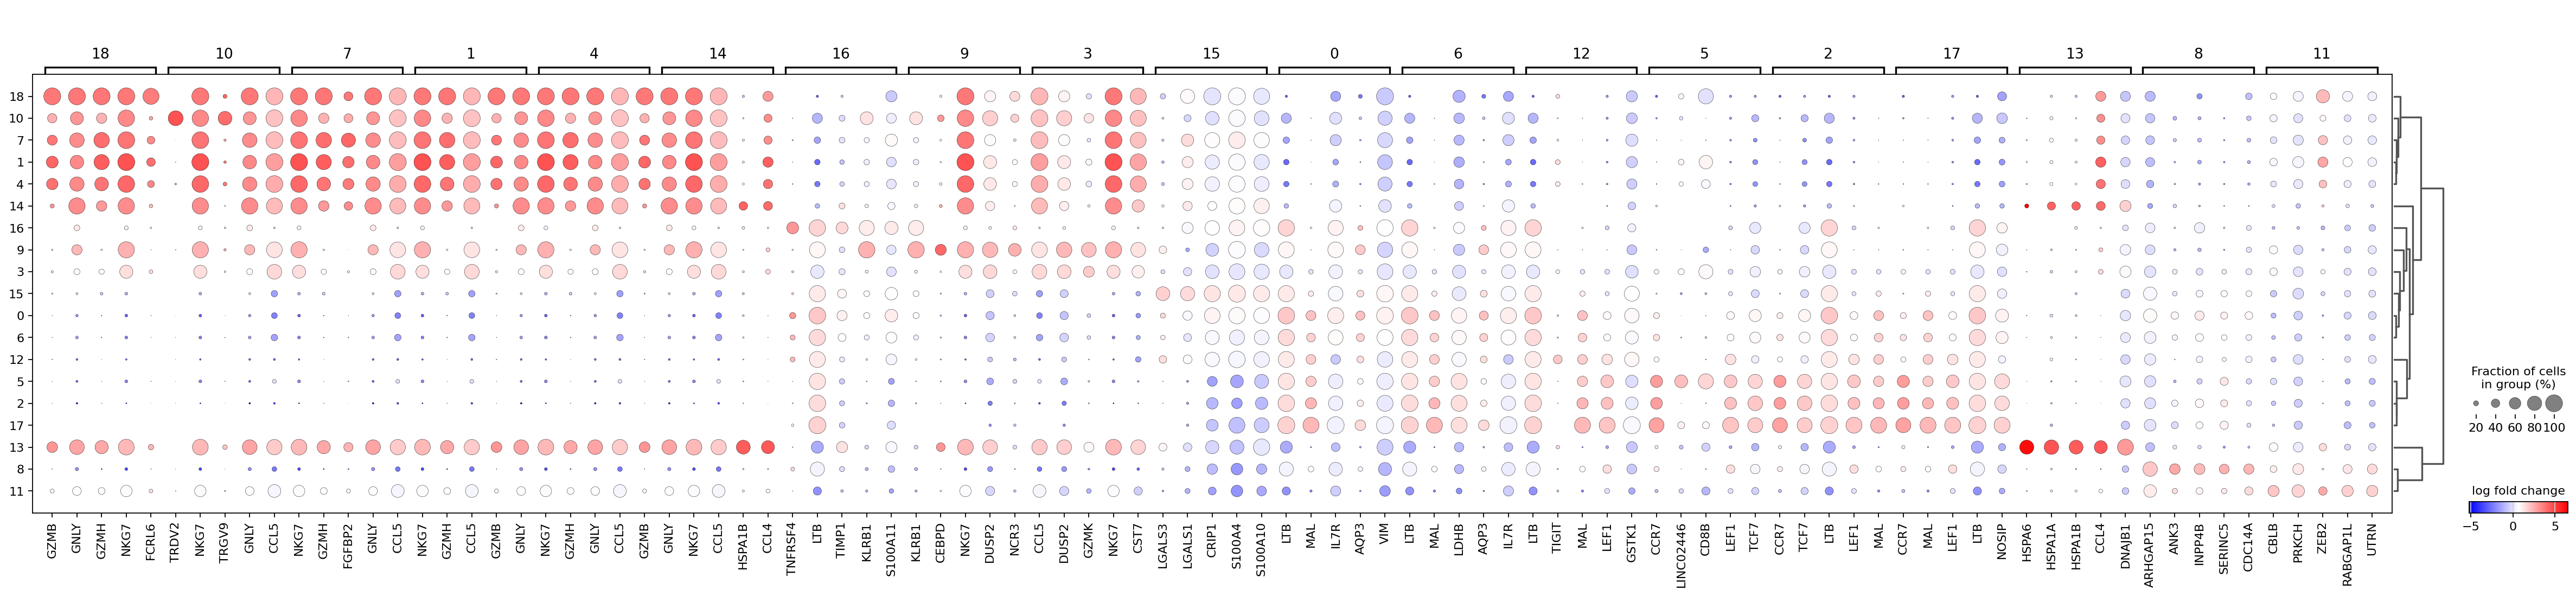

In [211]:
sc.pl.rank_genes_groups_dotplot(
    degs['adata'],
    n_genes=5,
    groupby="leiden_wnn_0.9",
    values_to_plot="logfoldchanges",
    standard_scale='var',
    cmap='bwr',
)

In [215]:
tcell_prot = tcells['prot'].copy()

In [32]:
sc.write("tcell_prot.h5ad", tcell_prot)

In [216]:
sub_raw_t_prot = sc.pp.subsample(tcell_prot, fraction=0.05, copy=True)

In [217]:
sub_raw_t_prot

AnnData object with n_obs × n_vars = 12916 × 137
    obs: 'Isotype_HTK888 percentile', 'Isotype_MOPC.173 percentile', 'Isotype_MOPC.21 percentile', 'Isotype_MPC.11 percentile', 'Isotype_RTK2071 percentile', 'Isotype_RTK2758 percentile', 'Isotype_RTK4530 percentile', 'sample', 'sample_name', 'visit_ref', 'subject_ref', 'disease_class', 'ethnicity', 'batch', 'leiden', 'c19_healthy_majority', 'c19_healthy_predicted', 'c19_healthy_over_clustering', 'immune_low_majority', 'immune_low_predicted', 'immune_low_over_clustering', 'type_label', 'leiden_wnn_0.6', 'leiden_wnn_0.7', 'leiden_wnn_0.8', 'leiden_wnn_0.9', 'leiden_wnn_1.0'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts', 'norm', 'trimmed'
    obsp: 'connectivities', 'distances'

In [231]:
# guess there's still a bug in using a layer for analysis.  For now, store any normalized data in something like adata.layers['norm']
# and then copy raw counts back to adata.X
sub_raw_t_prot.layers['norm'] = sub_raw_t_prot.X.copy()
sub_raw_t_prot.X = sub_raw_t_prot.layers['counts'].toarray().copy()

In [232]:
prot_degs = scvi_de(
    adata=sub_raw_t_prot, 
    groupby="leiden_wnn_0.9",
    return_df=True,
    return_model=True,
    modality="prot", 
    dispersion="protein",
    gene_likelihood="zinb", 
)

Sampling from binomial...: 100%|██████████| 10000/10000 [00:00<00:00, 22886.02it/s]
INFO     Using column names from adata.uns['prot_names']                                                           
INFO     Computing empirical prior initialization for protein background.                                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 238/400:  60%|█████▉    | 238/400 [03:45<02:33,  1.05it/s, v_num=1, train_loss_step=524, train_loss_epoch=532]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 526.910. Signaling Trainer to stop.
DE...: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


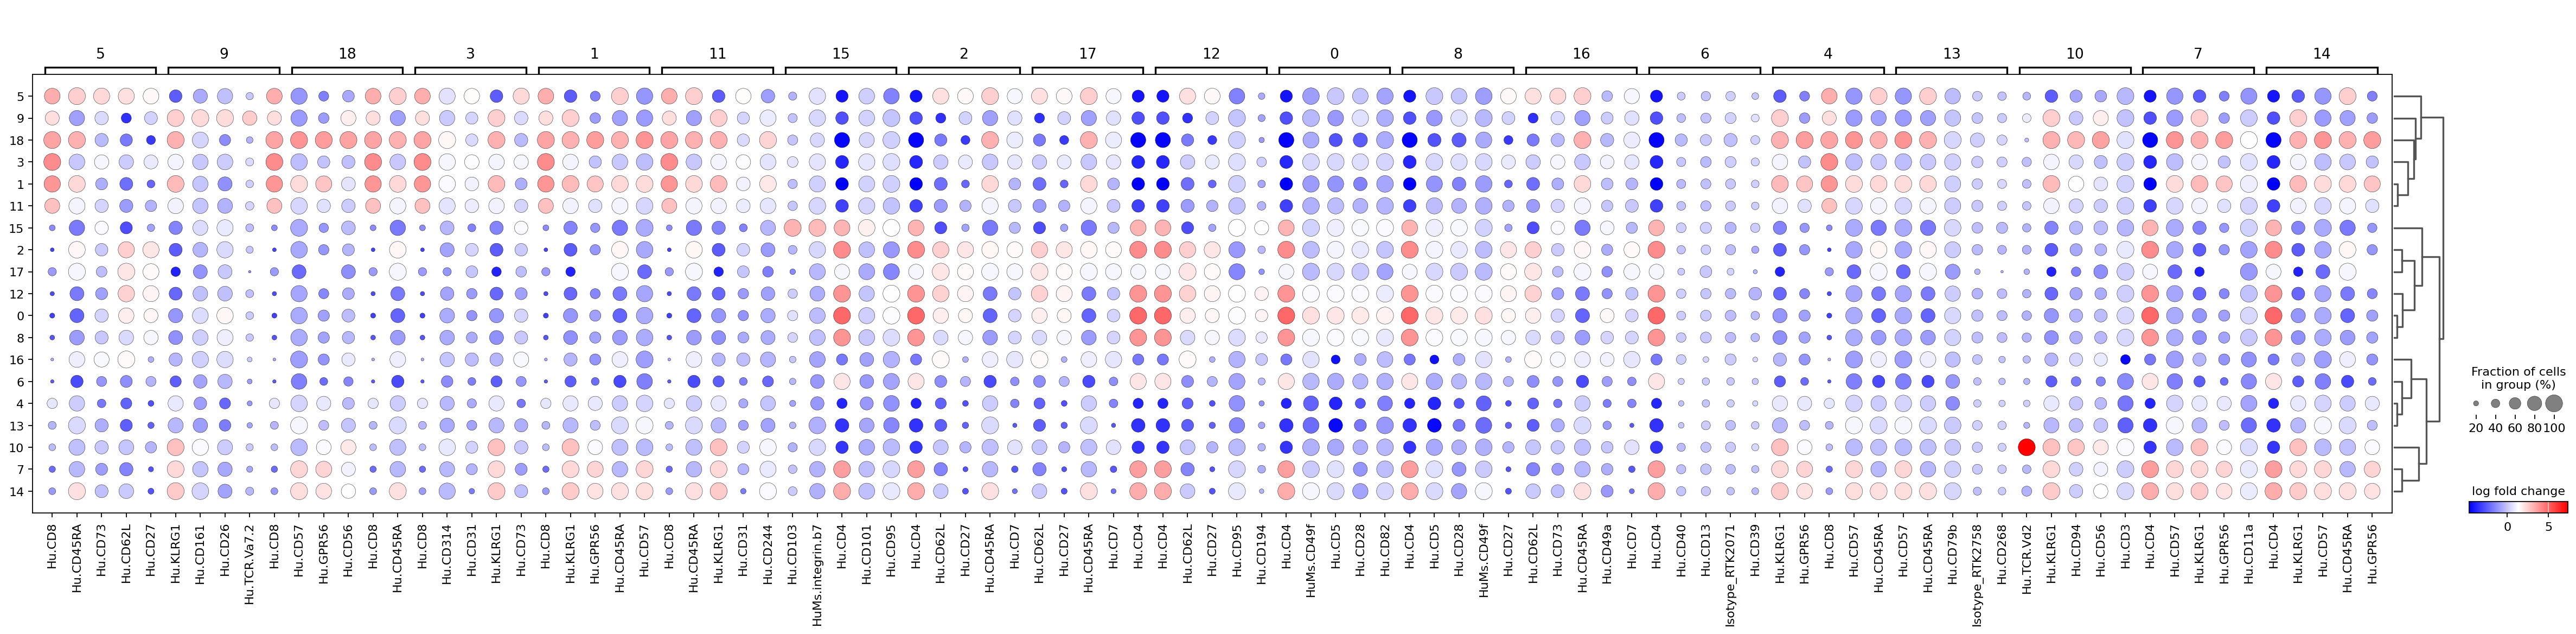

In [236]:
sc.pl.rank_genes_groups_dotplot(
    prot_degs['adata'],
    n_genes=5,
    groupby="leiden_wnn_0.9",
    values_to_plot="logfoldchanges",
    standard_scale='var',
    cmap='bwr',
)